<a href="https://colab.research.google.com/github/kluo9/Deap-Learning/blob/main/LifeLong_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Three families of lifelong learning
* Replay-based methods
* Regularization-based methods
* Parameter isolation methods

<img src="https://i.ibb.co/VDFJkWG/2019-12-29-17-25.png" width="100%">

In this assignment, we will go through EWC, MAS, SI, Remanian Walk, SCP Methods in the prior-focused methods of the regularization-based methods.

In [1]:
import argparse
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.utils.data.sampler as sampler
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import tqdm
from tqdm.auto import trange, tqdm

In [2]:
!nvidia-smi

Mon Jun 12 13:20:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Fix Random Seeds

In [3]:
def same_seeds(seed):
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
  np.random.seed(seed)  
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

same_seeds(0)

# Prepare Data

We utilize rotated MNIST as our training dataset.

So, first, we utilize 5 different rotations to generate 10 different rotated MNISTs as different tasks.

## Rotation and Transformation

In [4]:
# Rotate MNIST to generate 10 tasks

def _rotate_image(image, angle):
  if angle is None:
    return image

  image = transforms.functional.rotate(image, angle=angle)
  return image

def get_transform(angle=None):
  transform = transforms.Compose([transforms.ToTensor(),
                   transforms.Lambda(lambda x: _rotate_image(x, angle)),
                   Pad(28)
                   ])
  return transform

class Pad(object):
  def __init__(self, size, fill=0, padding_mode='constant'):
    self.size = size
    self.fill = fill
    self.padding_mode = padding_mode
    
  def __call__(self, img):
    # If the H and W of img is not equal to desired size,
    # then pad the channel of img to desired size.
    img_size = img.size()[1]
    assert ((self.size - img_size) % 2 == 0)
    padding = (self.size - img_size) // 2
    padding = (padding, padding, padding, padding)
    return F.pad(img, padding, self.padding_mode, self.fill)

class Data():
  def __init__(self, path, train=True, angle=None):
    transform = get_transform(angle)
    self.dataset = datasets.MNIST(root=os.path.join(path, "MNIST"), transform=transform, train=train, download=True)

## Dataloaders and Arguments

- Training Arguments
- Setup 5 different Rotations
- 5 Train DataLoader
- 5 Test DataLoader

In [5]:
class Args:
  task_number = 5
  epochs_per_task = 10
  lr = 1.0e-4
  batch_size = 128
  test_size=8192

args=Args()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# generate rotations for the tasks.

# generate rotated MNIST data from 10 different rotations.

angle_list = [20 * x for x in range(args.task_number)]

# prepare rotated MNIST datasets.

train_datasets = [Data('data', angle=angle_list[index]) for index in range(args.task_number)]
train_dataloaders = [DataLoader(data.dataset, batch_size=args.batch_size, shuffle=True) for data in train_datasets]

test_datasets = [Data('data', train=False, angle=angle_list[index]) for index in range(args.task_number)]
test_dataloaders = [DataLoader(data.dataset, batch_size=args.test_size, shuffle=True) for data in test_datasets]

100%|██████████| 9912422/9912422 [00:00<00:00, 162477475.30it/s]


Extracting data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 94785362.93it/s]


Extracting data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 154971012.99it/s]

Extracting data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 2654755.96it/s]

Extracting data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/MNIST/raw



## Visualization

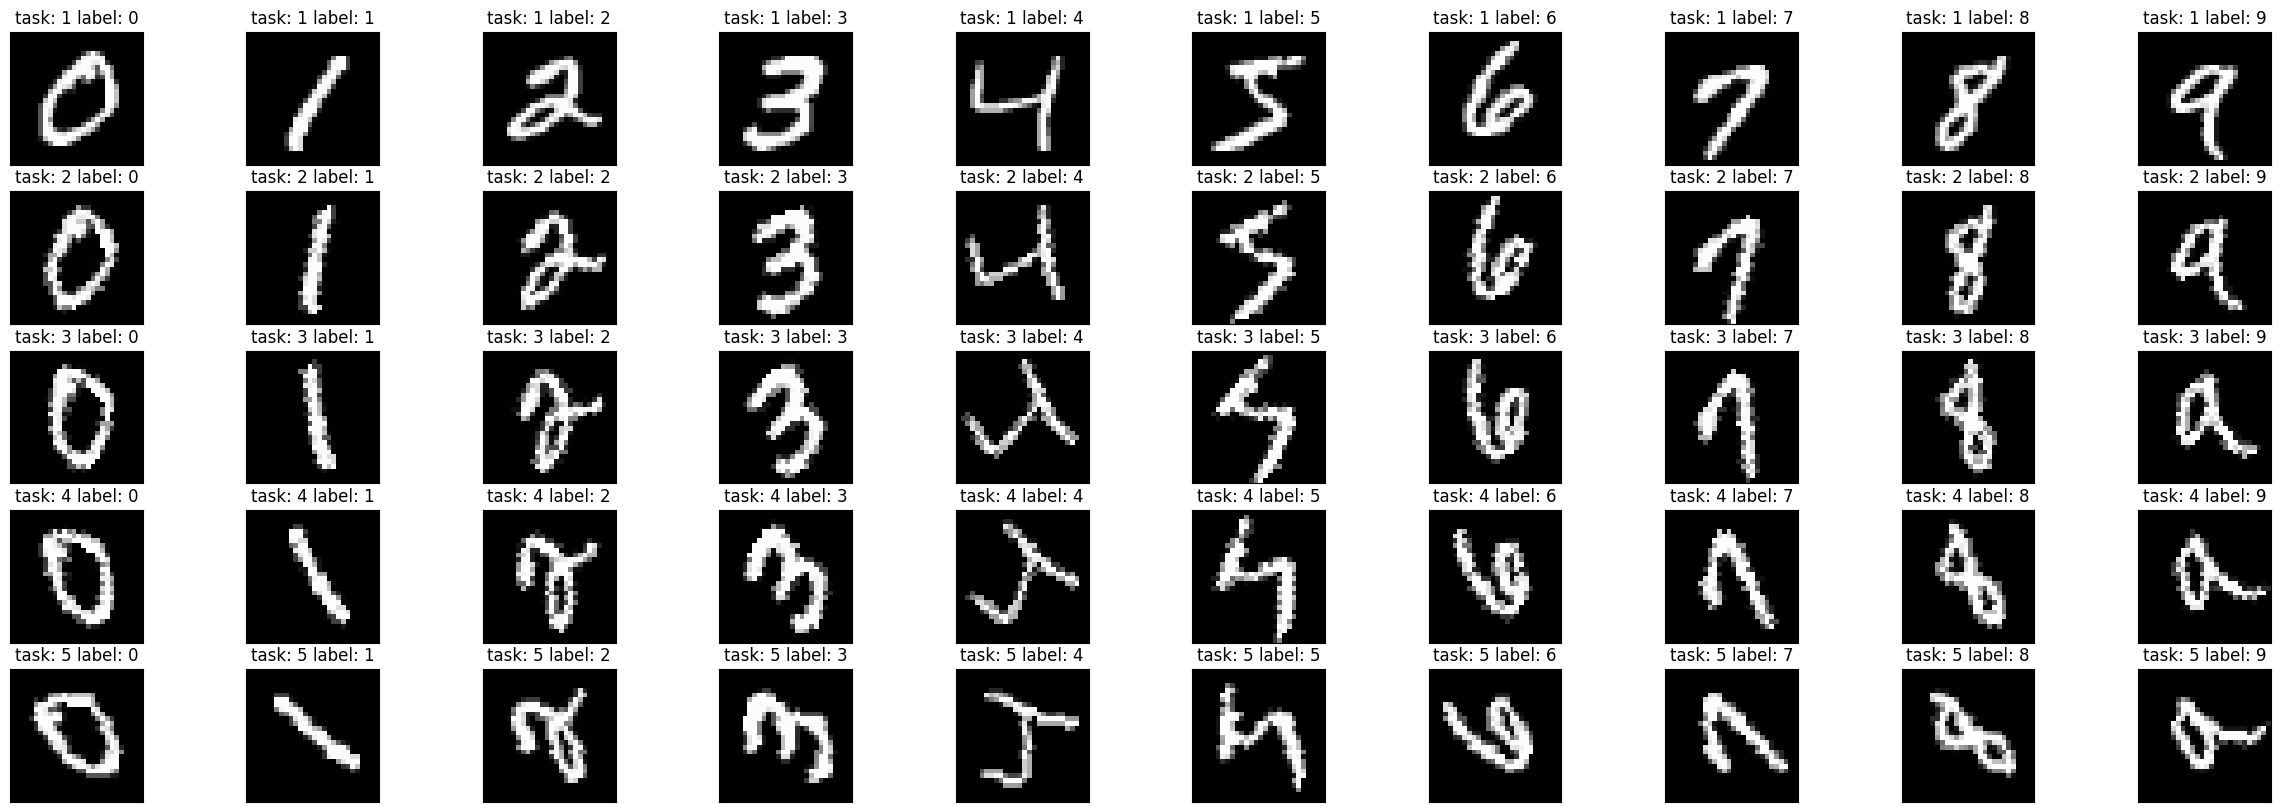

In [6]:
# Visualize label 0-9 1 sample MNIST picture in 5 tasks.
sample = [Data('data', angle=angle_list[index]) for index in range(args.task_number)]

plt.figure(figsize=(30, 10))
for task in range(5):
  target_list = []
  cnt = 0
  while (len(target_list) < 10):
    img, target = sample[task].dataset[cnt]
    cnt += 1
    if target in target_list:
      continue
    else:
      target_list.append(target)
    plt.subplot(5, 10, (task)*10 + target + 1)
    curr_img = np.reshape(img, (28, 28))
    plt.matshow(curr_img, cmap=plt.get_cmap('gray'), fignum=False)
    ax = plt.gca()
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    plt.title("task: " + str(task+1) + " " + "label: " + str(target), y=1)

# Model

## Model Architecture
To ensure fair comparison, fix our model architecture to 4 layers fully-connected network.

In [7]:
class Model(nn.Module):
  """
  Model architecture 
  1*28*28 (input) → 1024 → 512 → 256 → 10
  """
  def __init__(self):
    super(Model, self).__init__()
    self.fc1 = nn.Linear(1*28*28, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 256)
    self.fc4 = nn.Linear(256, 10)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = x.view(-1, 1*28*28)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    x = self.relu(x)
    x = self.fc4(x)
    return x

example = Model()
print(example)

Model(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)


## Train and Evaluate

Train

In [8]:
def train(model, optimizer, dataloader, epochs_per_task, lll_object, lll_lambda, test_dataloaders, evaluate, device, log_step=1):
  model.train()
  model.zero_grad()
  objective = nn.CrossEntropyLoss()
  acc_per_epoch = []
  loss = 1.0
  bar = trange(epochs_per_task, leave=False, desc=f"Epoch 1, Loss: {loss:.7f}")
  for epoch in bar:
    for imgs, labels in tqdm(dataloader, leave=False):            
      imgs, labels = imgs.to(device), labels.to(device)
      outputs = model(imgs)
      loss = objective(outputs, labels)
      total_loss = loss
      lll_loss = lll_object.penalty(model)
      total_loss += lll_lambda * lll_loss 
      lll_object.update(model)
      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()

      loss = total_loss.item()
      bar.set_description_str(desc=f"Epoch {epoch+1:2}, Loss: {loss:.7f}", refresh=True)
    acc_average  = []
    for test_dataloader in test_dataloaders: 
      acc_test = evaluate(model, test_dataloader, device)
      acc_average.append(acc_test)
    average=np.mean(np.array(acc_average))
    acc_per_epoch.append(average*100.0)
    bar.set_description_str(desc=f"Epoch {epoch+2:2}, Loss: {loss:.7f}", refresh=True)
                
  return model, optimizer, acc_per_epoch

Evaluate

In [9]:
def evaluate(model, test_dataloader, device):
    model.eval()
    correct_cnt = 0
    total = 0
    for imgs, labels in test_dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, pred_label = torch.max(outputs.data, 1)

        correct_cnt += (pred_label == labels.data).sum().item()
        total += torch.ones_like(labels.data).sum().item()
    return correct_cnt / total

# Methods

- Baseline
- EWC
- SI
- MAS
- RWalk
- SCP

## Baseline
The baseline class will do nothing in the regularization term.



In [18]:
# Baseline
class baseline(object):
  """
  baseline technique: do nothing in regularization term [initialize and all weight is zero]
  """
  def __init__(self, model, dataloader, device):
    self.model = model
    self.dataloader = dataloader
    self.device = device
    # extract all parameters in models
    self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad} 
    
    # store current parameters
    self.p_old = {} 

    # generate weight matrix
    self._precision_matrices = self._calculate_importance()  

    for n, p in self.params.items():
      # keep the old parameter in self.p_old
      self.p_old[n] = p.clone().detach() 

  def _calculate_importance(self):
    precision_matrices = {} 
    # initialize weight matrix（fill zero）
    for n, p in self.params.items(): 
      precision_matrices[n] = p.clone().detach().fill_(0)

    return precision_matrices

  def penalty(self, model: nn.Module):
    loss = 0
    for n, p in model.named_parameters():
      _loss = self._precision_matrices[n] * (p - self.p_old[n]) ** 2
      loss += _loss.sum()
    return loss
  
  def update(self, model):
    # do nothing
    return

In [19]:
# Baseline
print("RUN BASELINE")
model = Model()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

# initialize lifelong learning object (baseline class) without adding any regularization term.
lll_object=baseline(model=model, dataloader=None, device=device)
lll_lambda=0.0
baseline_acc=[]
task_bar = trange(len(train_dataloaders),desc="Task   1")

# iterate training on each task continually.
for train_indexes in task_bar:
  # Train each task
  model, _, acc_list = train(model, optimizer, train_dataloaders[train_indexes], args.epochs_per_task, 
                  lll_object, lll_lambda, evaluate=evaluate,device=device, test_dataloaders=test_dataloaders[:train_indexes+1])
  
  # get model weight to baseline class and do nothing!
  lll_object=baseline(model=model, dataloader=train_dataloaders[train_indexes],device=device)
  
  # new a optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
  
  # Collect average accuracy in each epoch
  baseline_acc.extend(acc_list)
  
  # display the information of the next task.
  task_bar.set_description_str(f"Task  {train_indexes+2:2}")

# average accuracy in each task per epoch! 
print(baseline_acc)
print("==================================================================================================")

RUN BASELINE


Task   1:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1, Loss: 1.0000000:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, Loss: 1.0000000:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, Loss: 1.0000000:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, Loss: 1.0000000:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, Loss: 1.0000000:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[92.39, 94.17999999999999, 95.39, 95.98, 96.72, 96.95, 97.21, 97.47, 97.72, 97.63, 95.51, 95.83, 95.725, 95.69, 95.49499999999999, 94.92, 95.31, 95.745, 94.955, 95.19999999999999, 90.93666666666667, 90.54666666666665, 89.93666666666668, 88.3, 88.29333333333334, 87.99333333333334, 88.70333333333335, 88.09333333333335, 87.77333333333334, 86.79333333333334, 82.16000000000001, 81.2975, 81.3775, 80.635, 79.97500000000001, 80.0275, 78.81750000000001, 79.84750000000001, 78.815, 78.885, 74.684, 73.83000000000001, 72.50000000000001, 73.01599999999999, 72.11, 71.926, 72.23200000000001, 71.99799999999999, 71.22800000000001, 71.344]


## EWC
Elastic Weight Consolidation

In the EWC algorithm, the definition of the loss function is shown below:
 $$\mathcal{L}_B = \mathcal{L}(\theta) + \sum_{i} \frac{\lambda}{2} F_i (\theta_{i} - \theta_{A,i}^{*})^2  $$
  
Assume we have a neural network with more than two parameters.

$F_i$ corresponds to the $i^{th}$ guard. Please do not modify this parameter, because it's important to task A.

The definition of $F$ is shown below.
$$ F = [ \nabla \log(p(y_n | x_n, \theta_{A}^{*})) \nabla \log(p(y_n | x_n, \theta_{A}^{*}))^T ] $$ 

We only take the diagonal value of the matrix to approximate each parameter's $F_i$.


In [10]:
# EWC
class ewc(object):
  """
  @article{kirkpatrick2017overcoming,
      title={Overcoming catastrophic forgetting in neural networks},
      author={Kirkpatrick, James and Pascanu, Razvan and Rabinowitz, Neil and Veness, Joel and Desjardins, Guillaume and Rusu, Andrei A and Milan, Kieran and Quan, John and Ramalho, Tiago and Grabska-Barwinska, Agnieszka and others},
      journal={Proceedings of the national academy of sciences},
      year={2017},
      url={https://arxiv.org/abs/1612.00796}
  }
  """
  def __init__(self, model, dataloader, device, prev_guards=[None]):
    self.model = model
    self.dataloader = dataloader
    self.device = device
    # extract all parameters in models
    self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad} 
    
    # initialize parameters
    self.p_old = {}
    # save previous guards
    self.previous_guards_list = prev_guards

    # generate Fisher (F) matrix for EWC
    self._precision_matrices = self._calculate_importance()                   

    # keep the old parameter in self.p_old
    for n, p in self.params.items():
      self.p_old[n] = p.clone().detach()       

  def _calculate_importance(self):
    precision_matrices = {}
    # initialize Fisher (F) matrix（all fill zero）and add previous guards
    for n, p in self.params.items(): 
      precision_matrices[n] = p.clone().detach().fill_(0)                 
      for i in range(len(self.previous_guards_list)):
        if self.previous_guards_list[i]:
          precision_matrices[n] += self.previous_guards_list[i][n]

    self.model.eval()
    if self.dataloader is not None:
      number_data = len(self.dataloader)
      for data in self.dataloader:
        self.model.zero_grad()
        # get image data
        input = data[0].to(self.device)
          
        # image data forward model
        output = self.model(input)
          
        # Simply use groud truth label of dataset.  
        label = data[1].to(self.device)
          
        # generate Fisher(F) matrix for EWC     
        loss = F.nll_loss(F.log_softmax(output, dim=1), label)
        loss.backward()   

        for n, p in self.model.named_parameters():
          # get the gradient of each parameter and square it, then average it in all validation set.                          
          precision_matrices[n].data += p.grad.data ** 2 / number_data   
                                                                
      precision_matrices = {n: p for n, p in precision_matrices.items()}
    return precision_matrices

  def penalty(self, model: nn.Module):
    loss = 0
    for n, p in model.named_parameters():
      # generate the final regularization term by the ewc weight (self._precision_matrices[n]) and the square of weight difference ((p - self.p_old[n]) ** 2).  
      _loss = self._precision_matrices[n] * (p - self.p_old[n]) ** 2
      loss += _loss.sum()
    return loss
  
  def update(self, model):
    # do nothing
    return 

In [12]:
# EWC
print("RUN EWC")
model = Model()
model = model.to(device)
# initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

# initialize lifelong learning object for EWC
lll_object=ewc(model=model, dataloader=None, device=device)

# setup the coefficient value of regularization term.
lll_lambda=100
ewc_acc= []
task_bar = trange(len(train_dataloaders),desc="Task   1")
prev_guards = []

# iterate training on each task continually.
for train_indexes in task_bar:
  # Train Each Task
  model, _, acc_list = train(model, optimizer, train_dataloaders[train_indexes], args.epochs_per_task, lll_object, lll_lambda, evaluate=evaluate,device=device, test_dataloaders=test_dataloaders[:train_indexes+1])
  
  # get model weight and calculate guidance for each weight
  prev_guards.append(lll_object._precision_matrices)
  lll_object=ewc(model=model, dataloader=train_dataloaders[train_indexes], device=device, prev_guards=prev_guards)

  # new a Optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

  # collect average accuracy in each epoch
  ewc_acc.extend(acc_list)

  # Update tqdm displayer
  task_bar.set_description_str(f"Task  {train_indexes+2:2}")

# average accuracy in each task per epoch!     
print(ewc_acc)
print("==================================================================================================")

RUN EWC


Task   1:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1, Loss: 1.0000000:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, Loss: 1.0000000:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, Loss: 1.0000000:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, Loss: 1.0000000:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, Loss: 1.0000000:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

[92.27, 94.53, 95.46, 95.95, 96.64, 97.03, 97.2, 97.53, 97.64, 97.83, 95.67, 96.02999999999999, 95.55, 95.505, 95.10000000000001, 95.03, 95.15, 95.51, 95.66, 94.705, 91.38666666666667, 89.82333333333334, 89.26000000000002, 88.09, 88.50000000000001, 88.27999999999999, 88.26, 87.65333333333332, 86.88666666666668, 87.46333333333332, 82.2225, 81.3825, 80.7825, 80.4775, 78.82000000000001, 78.96000000000001, 79.10249999999999, 79.32999999999998, 80.2, 77.77000000000001, 75.028, 73.394, 72.312, 72.524, 71.964, 72.038, 71.936, 72.756, 72.356, 72.858]
